In [94]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import nltk
from nltk.corpus import stopwords
import re


In [87]:
def bar_chart(data_dict, title='', xlabel='', ylabel=''):
    plt.figure(figsize=(8, 6))
    plt.bar(data_dict.keys(), data_dict.values(), color='steelblue')
    plt.title(title)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.xticks(list(data_dict.keys()))
    plt.show()


# Carga de Datos

In [88]:

data_reviews = pd.read_csv('../data/olist_order_reviews_dataset.csv')

data_reviews.head()

,review_id,order_id,review_score,review_comment_title,review_comment_message,review_creation_date,review_answer_timestamp
0,7bc2406110b926393aa56f80a40eba40,73fc7af87114b39712e6da79b0a377eb,4,NaN,NaN,2018-01-18 00:00:00,2018-01-18 21:46:59
1,80e641a11e56f04c1ad469d5645fdfde,a548910a1c6147796b98fdf73dbeba33,5,NaN,NaN,2018-03-10 00:00:00,2018-03-11 03:05:13
2,228ce5500dc1d8e020d8d1322874b6f0,f9e4b658b201a9f2ecdecbb34bed034b,5,NaN,NaN,2018-02-17 00:00:00,2018-02-18 14:36:24
3,e64fb393e7b32834bb789ff8bb30750e,658677c97b385a9be170737859d3511b,5,NaN,Recebi bem antes do prazo estipulado.,2017-04-21 00:00:00,2017-04-21 22:02:06
4,f7c4243c7fe1938f181bec41a392bdeb,8e6bfb81e283fa7e4f11123a3fb894f1,5,NaN,Parabéns lojas lannister adorei comprar pela I...,2018-03-01 00:00:00,2018-03-02 10:26:53


# Limpieza de datos

In [89]:
data_reviews.info()

<class 'pandas.DataFrame'>
RangeIndex: 99224 entries, 0 to 99223
Data columns (total 7 columns):
 #   Column                   Non-Null Count  Dtype
---  ------                   --------------  -----
 0   review_id                99224 non-null  str  
 1   order_id                 99224 non-null  str  
 2   review_score             99224 non-null  int64
 3   review_comment_title     11568 non-null  str  
 4   review_comment_message   40977 non-null  str  
 5   review_creation_date     99224 non-null  str  
 6   review_answer_timestamp  99224 non-null  str  
dtypes: int64(1), str(6)
memory usage: 5.3 MB


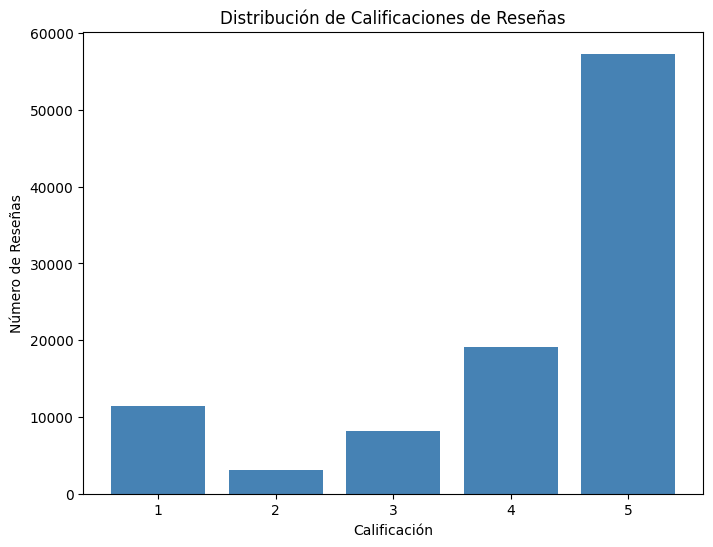

In [90]:

bar_chart(
    data_reviews['review_score'].value_counts().to_dict(),
    title='Distribución de Calificaciones de Reseñas',
    xlabel='Calificación',
    ylabel='Número de Reseñas'
)

In [91]:
def calculate_stats_per_row (data, column):
    data[column] = data[column].fillna('')
    
    # Cantidad de caracteres
    data['char_count'] = data[column].str.len()
    
    # Cantidad de palabras
    data['word_count'] = data[column].apply(lambda x: len(x.split()))
    
    # Cantidad de oraciones (aproximado por puntos, signos de exclamación e interrogación)
    data['sentence_count'] = data[column].apply(
        lambda x: max(1, len(re.split(r'[.!?]+', x.strip())) - 1)
    )
    
    # Longitud promedio de palabras
    data['avg_word_length'] = data[column].apply(
        lambda x: sum(len(word) for word in x.split()) / len(x.split()) if x.split() else 0
    )
    
    # Palabras por oración
    data['words_per_sentence'] = data['word_count'] / data['sentence_count']
    
    # Palabras únicas
    data['unique_words_count'] = data[column].apply(
        lambda x: len(set(x.lower().split()))
    )
    # Signos de exclamación
    data['exclamation_count'] = data[column].str.count('!')
    
    # Signos de interrogación
    data['question_count'] = data[column].str.count(r'\?')
    
    # Comas
    data['comma_count'] = data[column].str.count(',')
    
    # Puntos
    data['period_count'] = data[column].str.count(r'\.')
    return data

data_reviews['full_text'] = data_reviews['review_comment_title'].fillna('') + ' ' + data_reviews['review_comment_message'].fillna('')

calculate_stats_per_row(data_reviews, 'full_text')  



,review_id,order_id,review_score,review_comment_title,review_comment_message,review_creation_date,review_answer_timestamp,full_text,char_count,word_count,sentence_count,avg_word_length,words_per_sentence,unique_words_count,exclamation_count,question_count,comma_count,period_count
0,7bc2406110b926393aa56f80a40eba40,73fc7af87114b39712e6da79b0a377eb,4,NaN,NaN,2018-01-18 00:00:00,2018-01-18 21:46:59,,1,0,1,0.000000,0.0,0,0,0,0,0
1,80e641a11e56f04c1ad469d5645fdfde,a548910a1c6147796b98fdf73dbeba33,5,NaN,NaN,2018-03-10 00:00:00,2018-03-11 03:05:13,,1,0,1,0.000000,0.0,0,0,0,0,0
2,228ce5500dc1d8e020d8d1322874b6f0,f9e4b658b201a9f2ecdecbb34bed034b,5,NaN,NaN,2018-02-17 00:00:00,2018-02-18 14:36:24,,1,0,1,0.000000,0.0,0,0,0,0,0
3,e64fb393e7b32834bb789ff8bb30750e,658677c97b385a9be170737859d3511b,5,NaN,Recebi bem antes do prazo estipulado.,2017-04-21 00:00:00,2017-04-21 22:02:06,Recebi bem antes do prazo estipulado.,38,6,1,5.333333,6.0,6,0,0,0,1
4,f7c4243c7fe1938f181bec41a392bdeb,8e6bfb81e283fa7e4f11123a3fb894f1,5,NaN,Parabéns lojas lannister adorei comprar pela I...,2018-03-01 00:00:00,2018-03-02 10:26:53,Parabéns lojas lannister adorei comprar pela ...,101,15,1,5.733333,15.0,14,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
99219,574ed12dd733e5fa530cfd4bbf39d7c9,2a8c23fee101d4d5662fa670396eb8da,5,NaN,NaN,2018-07-07 00:00:00,2018-07-14 17:18:30,,1,0,1,0.000000,0.0,0,0,0,0,0
99220,f3897127253a9592a73be9bdfdf4ed7a,22ec9f0669f784db00fa86d035cf8602,5,NaN,NaN,2017-12-09 00:00:00,2017-12-11 20:06:42,,1,0,1,0.000000,0.0,0,0,0,0,0
99221,b3de70c89b1510c4cd3d0649fd302472,55d4004744368f5571d1f590031933e4,5,NaN,"Excelente mochila, entrega super rápida. Super...",2018-03-22 00:00:00,2018-03-23 09:10:43,"Excelente mochila, entrega super rápida. Supe...",68,9,2,6.555556,4.5,8,1,0,1,1
99222,1adeb9d84d72fe4e337617733eb85149,7725825d039fc1f0ceb7635e3f7d9206,4,NaN,NaN,2018-07-01 00:00:00,2018-07-02 12:59:13,,1,0,1,0.000000,0.0,0,0,0,0,0


In [106]:
data_reviews.describe()

,review_score,char_count,word_count,sentence_count,avg_word_length,words_per_sentence,unique_words_count,exclamation_count,question_count,comma_count,period_count
count,99224.000000,99224.000000,99224.000000,99224.000000,99224.000000,99224.000000,99224.000000,99224.000000,99224.000000,99224.000000,99224.000000
mean,4.086421,30.738229,5.041462,1.166714,2.271806,3.788367,4.674867,0.116696,0.012164,0.227929,0.415353
std,1.347579,49.673819,8.604777,0.614505,2.876580,6.471976,7.728294,0.792043,0.443749,0.709949,1.349033
min,1.000000,1.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,4.000000,1.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,5.000000,1.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,5.000000,46.000000,7.000000,1.000000,4.875000,6.000000,7.000000,0.000000,0.000000,0.000000,0.000000
max,5.000000,229.000000,48.000000,89.000000,200.000000,48.000000,40.000000,153.000000,117.000000,92.000000,200.000000


In [110]:
def calculate_general_stats(data,column):
    texts = data[column].fillna('')
    
    # Concatenar todo el texto
    all_text = ' '.join(texts)
    all_words = all_text.lower().split()
    stats = {
        # Básicas
        'total_texts': len(data),
        'total_words': len(all_words),
        'vocabulary_size': len(set(all_words)),
        
        # Promedios
        'mean_word_count': data['word_count'].mean(),
        'median_word_count': data['word_count'].median(),
        'std_word_count': data['word_count'].std(),
        'min_word_count': data['word_count'].min(),
        'max_word_count': data['word_count'].max(),
        
        # Calidad
        'empty_count': (data[column] == '').sum(),
        'duplicate_count': data[column].duplicated().sum(),
        'duplicate_ratio': data[column].duplicated().sum() / len(data),
        'very_short_texts': (data['char_count'] < 10).sum(),
        'very_long_texts': (data['char_count'] > 1000).sum(),
        
    }
    return stats

calculate_general_stats(data_reviews, 'full_text')

{'total_texts': 99224,
 'total_words': 500234,
 'vocabulary_size': 30483,
 'mean_word_count': np.float64(5.041461743126663),
 'median_word_count': np.float64(0.0),
 'std_word_count': np.float64(8.604776697751602),
 'min_word_count': np.int64(0),
 'max_word_count': np.int64(48),
 'empty_count': np.int64(0),
 'duplicate_count': np.int64(61301),
 'duplicate_ratio': np.float64(0.6178041602838023),
 'very_short_texts': np.int64(58965),
 'very_long_texts': np.int64(0)}